In [106]:
import importlib
from __imports__ import *
import data, LSTM_returns, optimization
importlib.reload(data)

<module 'data' from 'c:\\Users\\27904\\OneDrive\\桌面\\crypto\\AAA_Thursday1\\data\\__init__.py'>

In [107]:
df = data.load_asset('DOGEUSDT', sampling='1d')
df = data.add_fear_and_greed(df)
# Restrict data after 2022
df = df[df.index >= '2020-01-01']
df.head()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,F&G,F&G category
Open time,,,,,,,,,,,
2020-01-01,0.002014,0.002039,0.002000,0.002024,31462868.0,63641.724359,594,15348147.0,31023.057024,37.0,Fear
2020-01-02,0.002024,0.002040,0.001948,0.001995,191887309.0,383678.683621,3047,102172168.0,204688.967802,39.0,Fear
2020-01-03,0.001999,0.002036,0.001968,0.002024,109005714.0,219205.872015,1585,56166206.0,112959.680220,38.0,Fear
2020-01-04,0.002018,0.002103,0.002015,0.002058,123468609.0,252973.419648,1739,70521098.0,144561.898293,38.0,Fear
2020-01-05,0.002059,0.002092,0.002036,0.002070,66437147.0,137479.874863,1381,31852955.0,65947.573882,39.0,Fear


In [108]:
import ta  # technical analysis library

look_back = 14

# Return: Daily log return
df['Return'] = np.log(df['Close'] / df['Close'].shift(1))

# Risk: Rolling standard deviation of returns (volatility)
df['Risk'] = df['Return'].rolling(window=look_back).std()

# RSI: Relative Strength Index
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=look_back).rsi()

# ADX: Average Directional Index
df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=look_back).adx()

# MOM: Momentum indicator (difference between close and n periods ago)
df['MOM'] = df['Close'] - df['Close'].shift(look_back)

# HL: High-Low spread (volatility proxy)
df['HL'] = df['High'] - df['Low']

# HO: High-Open gap
df['HO'] = df['High'] - df['Open']

# LO: Low-Open gap
df['LO'] = df['Low'] - df['Open']

df['buy_pressure_ratio'] = df['Taker buy quote asset volume'] / df['Quote asset volume']
df['trades_per_volume'] = df['Number of trades'] / df['Quote asset volume']

def compute_slope(series):
    y = series.values
    x = np.arange(len(y))
    if len(y) == 0:
        return np.nan
    slope = np.polyfit(x, y, 1)[0]
    return slope

# Assume df['Close'] already exists
df['slope'] = df['Close'].rolling(window=look_back).apply(compute_slope, raw=False)

# Drop rows with NaN due to indicator lookback
df = df.dropna()

# Show result
print(df[['Return', 'Risk', 'RSI', 'ADX', 'MOM', 'HL', 'HO', 'LO']].head())

              Return      Risk        RSI  ADX       MOM        HL  \
Open time                                                            
2020-01-15  0.003725  0.028466  78.098014  0.0  0.000342  0.000171   
2020-01-16 -0.016743  0.028619  71.548504  0.0  0.000332  0.000090   
2020-01-17  0.066159  0.032208  79.169397  0.0  0.000463  0.000188   
2020-01-18  0.009883  0.032227  80.061730  0.0  0.000454  0.000078   
2020-01-19 -0.046162  0.036038  66.078625  0.0  0.000329  0.000256   

                      HO        LO  
Open time                           
2020-01-15  1.420000e-04 -0.000029  
2020-01-16  8.000000e-07 -0.000089  
2020-01-17  1.692000e-04 -0.000018  
2020-01-18  3.700000e-05 -0.000041  
2020-01-19  6.960000e-05 -0.000187  


In [109]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'F&G', 'F&G category', 'Return', 'Risk',
       'RSI', 'ADX', 'MOM', 'HL', 'HO', 'LO', 'buy_pressure_ratio',
       'trades_per_volume', 'slope'],
      dtype='object')

In [110]:
cols_to_drop = ['Open', 'High', 'Low', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume','F&G', ]  # add more columns if needed

df = df.drop(columns=cols_to_drop)

In [111]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

c:\Users\27904\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:33:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


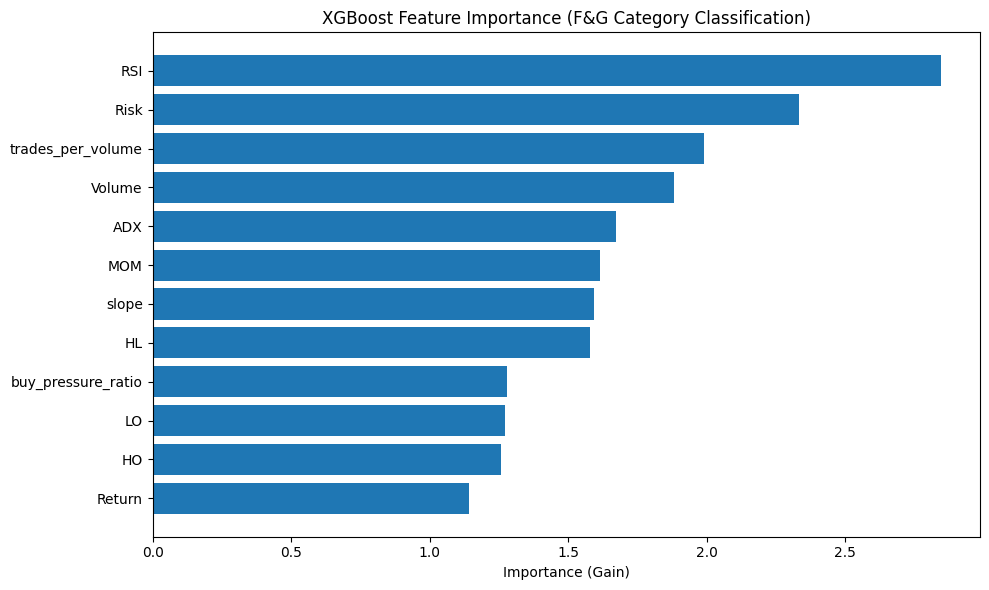

(0.6482939632545932,
 '               precision    recall  f1-score   support\n\n Extreme Fear       0.65      0.76      0.70        70\nExtreme Greed       0.72      0.73      0.72        52\n         Fear       0.63      0.57      0.60        91\n        Greed       0.64      0.73      0.68       110\n      Neutral       0.62      0.41      0.49        58\n\n     accuracy                           0.65       381\n    macro avg       0.65      0.64      0.64       381\n weighted avg       0.65      0.65      0.64       381\n',
                Feature  Importance (Gain)
 3                  RSI           2.845187
 2                 Risk           2.333083
 10   trades_per_volume           1.991278
 0               Volume           1.880886
 4                  ADX           1.673278
 5                  MOM           1.614940
 11               slope           1.595123
 6                   HL           1.579905
 9   buy_pressure_ratio           1.278970
 8                   LO           1.

In [112]:
le = LabelEncoder()
df['target'] = le.fit_transform(df['F&G category'])

# Define features and target
features = [
    'Volume', 'Return', 'Risk', 'RSI', 'ADX', 'MOM', 'HL',
    'HO', 'LO', 'buy_pressure_ratio', 'trades_per_volume','slope'
]
X = df[features]
y = df['target']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)

# Feature importance
booster = model.get_booster()
importance_gain = booster.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance_gain.keys()),
    'Importance (Gain)': list(importance_gain.values())
}).sort_values(by='Importance (Gain)', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance (Gain)'])
plt.xlabel("Importance (Gain)")
plt.title("XGBoost Feature Importance (F&G Category Classification)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

accuracy, report, importance_df.head(10)

In [114]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

# Merge F&G category into 3 classes
def map_fg_category(cat):
    if cat in ['Extreme Fear', 'Fear']:
        return 'Bearish'
    elif cat in ['Greed', 'Extreme Greed']:
        return 'Bullish'
    else:
        return 'Neutral'

df['F&G category merged'] = df['F&G category'].apply(map_fg_category)
le = LabelEncoder()
df['target'] = le.fit_transform(df['F&G category merged'])
#df['target'] = le.fit_transform(df['F&G category'])

# Define features and target
features = [
    'Volume', 'Return', 'Risk', 'RSI', 'ADX', 'MOM', 'HL',
    'HO', 'LO', 'buy_pressure_ratio', 'trades_per_volume', 'slope'
]
X = df[features]
y = df['target']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 30, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
        'objective': 'multi:softmax',
        'num_class': 3,
        'eval_metric': 'mlogloss',
        'tree_method': 'hist',
        'use_label_encoder': False
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    preds = model.predict(X_val)
    return f1_score(y_val, preds, average='macro')

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

# Best parameters and final model
best_params = study.best_params
best_params.update({
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'tree_method': 'hist',
    'use_label_encoder': False
})
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train)

# Final evaluation
y_pred = final_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=le.classes_)

# Feature importance
booster = final_model.get_booster()
importance_gain = booster.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance_gain.keys()),
    'Importance (Gain)': list(importance_gain.values())
}).sort_values(by='Importance (Gain)', ascending=False)

accuracy, report, importance_df.head(10)


[I 2025-04-29 19:34:55,264] A new study created in memory with name: no-name-6a876d3a-edcf-4763-b98e-30fed0057ac3
c:\Users\27904\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:34:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-04-29 19:34:55,352] Trial 0 finished with value: 0.6388239071602221 and parameters: {'n_estimators': 36, 'max_depth': 5, 'learning_rate': 0.12404682119284398, 'subsample': 0.6381698267318238, 'colsample_bytree': 0.9754274519547039, 'gamma': 0.17210480350608004, 'min_child_weight': 1}. Best is trial 0 with value: 0.6388239071602221.
c:\Users\27904\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:34:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(d

(0.7690288713910761,
 '              precision    recall  f1-score   support\n\n     Bearish       0.77      0.83      0.80       161\n     Bullish       0.78      0.83      0.81       162\n     Neutral       0.69      0.43      0.53        58\n\n    accuracy                           0.77       381\n   macro avg       0.75      0.70      0.71       381\nweighted avg       0.76      0.77      0.76       381\n',
                Feature  Importance (Gain)
 3                  RSI           3.362385
 5                  MOM           2.644799
 2                 Risk           2.264390
 0               Volume           2.009094
 4                  ADX           1.842304
 10   trades_per_volume           1.759972
 6                   HL           1.693940
 11               slope           1.602989
 9   buy_pressure_ratio           1.271339
 7                   HO           1.243581)